In [3]:
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split, WeightedRandomSampler
import random
from sklearn.utils.class_weight import compute_class_weight
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import cv2
from PIL import Image
from torchvision import datasets
import zipfile
from torchvision import transforms, datasets, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from torch.utils.data import Subset
import seaborn as sns
from collections import Counter

2025-04-30 21:41:10.225489: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 21:41:11.489530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 21:41:14.632317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with zipfile.ZipFile('/home/jupyter/datasphere/dl-2025-competition-1.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/jupyter/datasphere/data')
    
!ls -R /home/jupyter/datasphere/data

/home/jupyter/datasphere/data:
data
sample_submission.csv

/home/jupyter/datasphere/data/data:
test
train

/home/jupyter/datasphere/data/data/test:
0.png
1.png
10.png
100.png
1000.png
1001.png
1002.png
1003.png
1004.png
1005.png
1006.png
1007.png
1008.png
1009.png
101.png
1010.png
1011.png
1012.png
1013.png
1014.png
1015.png
1016.png
1017.png
1018.png
1019.png
102.png
1020.png
1021.png
1022.png
1023.png
1024.png
1025.png
1026.png
1027.png
1028.png
1029.png
103.png
1030.png
1031.png
1032.png
1033.png
1034.png
1035.png
1036.png
1037.png
1038.png
1039.png
104.png
1040.png
1041.png
1042.png
1043.png
1044.png
1045.png
1046.png
1047.png
1048.png
1049.png
105.png
1050.png
1051.png
1052.png
1053.png
1054.png
1055.png
1056.png
1057.png
1058.png
1059.png
106.png
1060.png
1061.png
1062.png
1063.png
1064.png
1065.png
1066.png
1067.png
1068.png
1069.png
107.png
1070.png
1071.png
1072.png
1073.png
1074.png
1075.png
1076.png
1077.png
1078.png
1079.png
108.png
1080.png
1081.png
1082.png
1083.png
1084.

In [4]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True  # Аугментация
)

train_generator = train_datagen.flow_from_directory(
    '/home/jupyter/datasphere/data/data/train',  # Путь к train
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/home/jupyter/datasphere/data/data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#Тестовые данные
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/home/jupyter/datasphere/data/data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # Если нет классов
    shuffle=False
)

Found 7649 images belonging to 100 classes.
Found 1861 images belonging to 100 classes.
Found 0 images belonging to 0 classes.


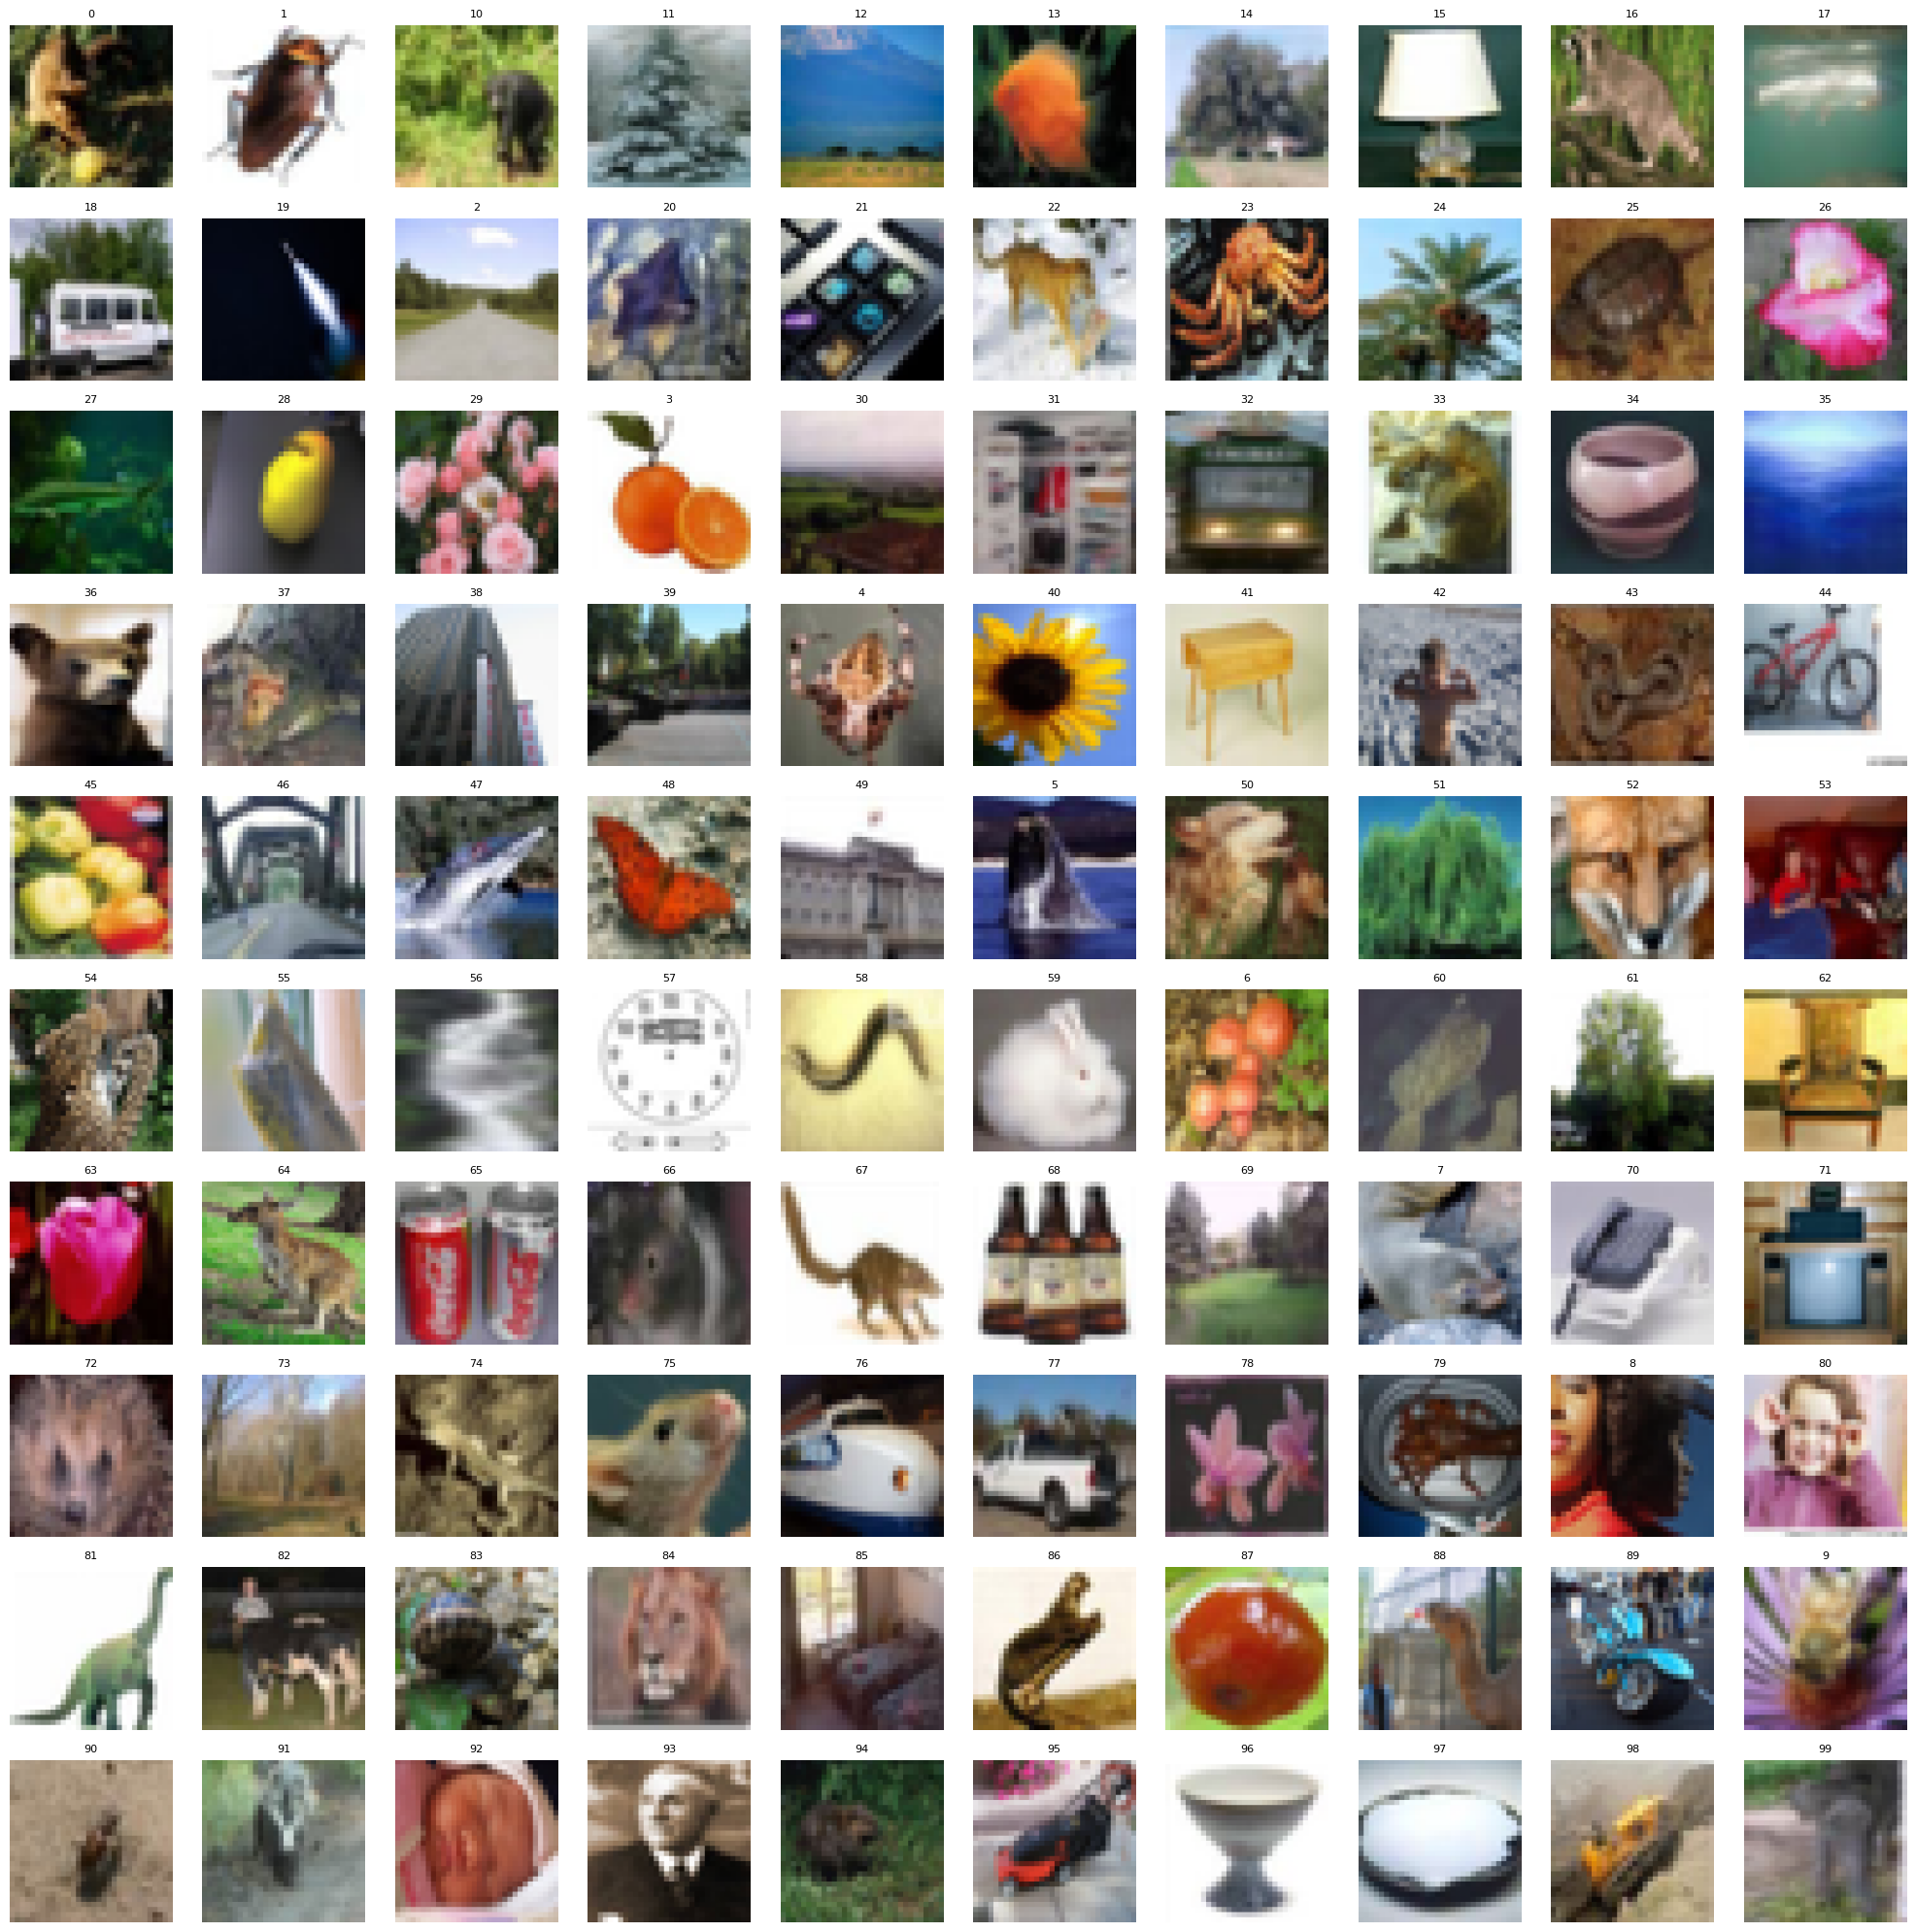

In [5]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10, figsize=(20, 20))  
axes = axes.ravel()
for class_id in range(num_classes):
    for images, labels in train_generator:
        class_mask = np.argmax(labels, axis=1) == class_id
        if np.any(class_mask):
            img = images[class_mask][0]
            axes[class_id].imshow(img)
            axes[class_id].set_title(class_names[class_id], fontsize=8)
            axes[class_id].axis('off')
            break

plt.tight_layout()
plt.show()

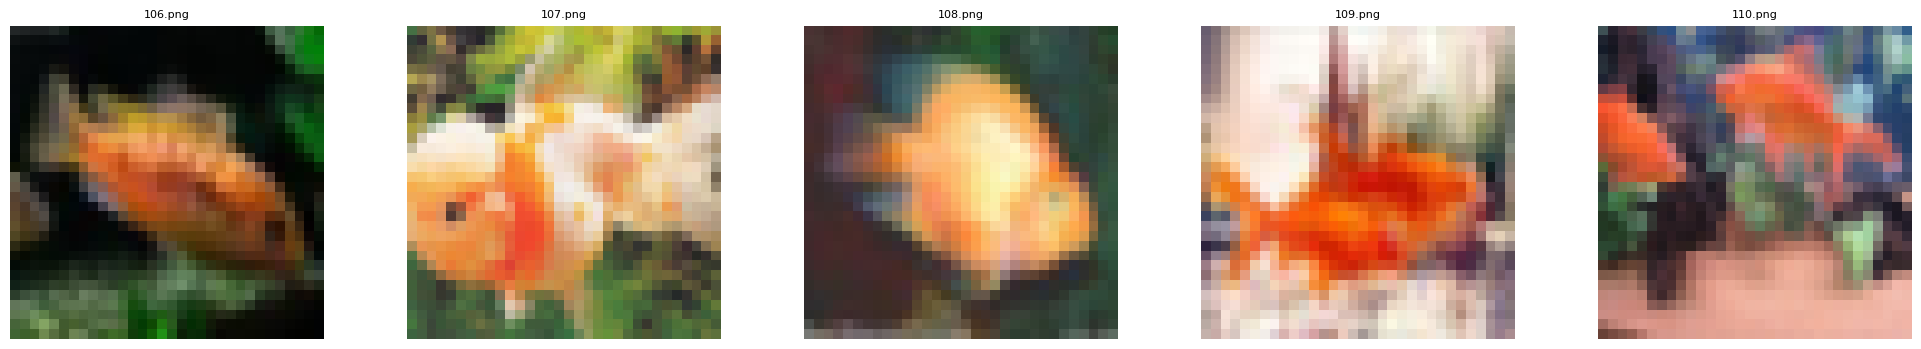

In [7]:
class_name = "13" 
class_path = os.path.join('/home/jupyter/datasphere/data/data/train', class_name)
image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

max_images = 5  # Максимальное количество изображений для показа

plt.figure(figsize=(20, 20))
for i, img_file in enumerate(image_files[:max_images], 1):
    img_path = os.path.join(class_path, img_file)
    img = Image.open(img_path)
    
    plt.subplot(6, 5, i)  # 6 строк, 5 колонок
    plt.imshow(img)
    plt.title(f"{img_file}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

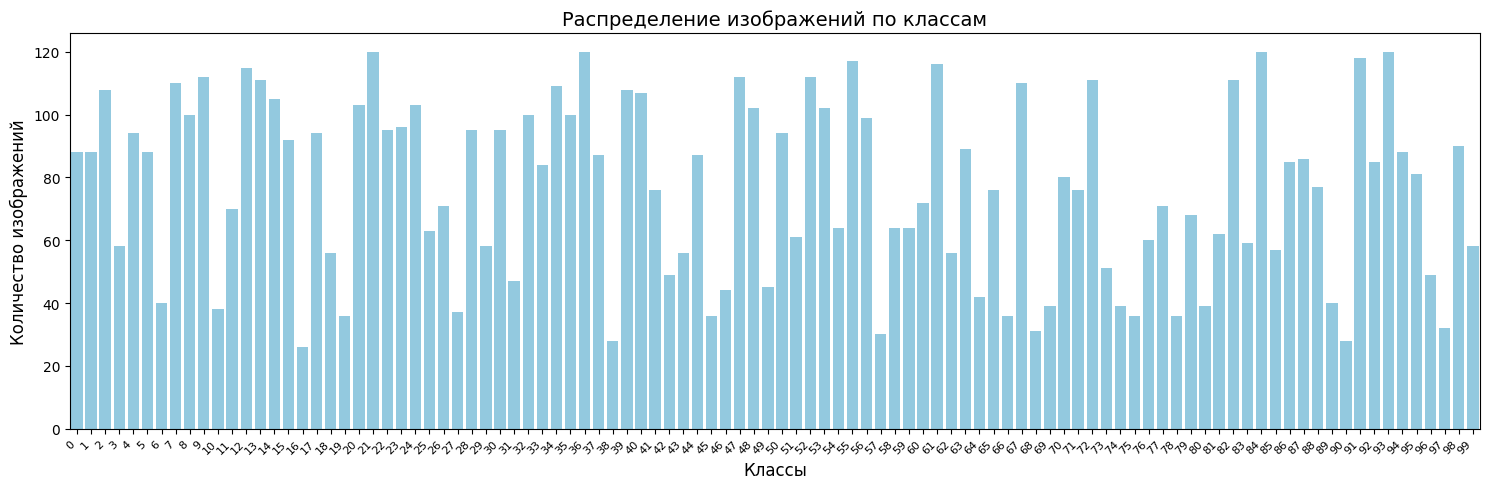

In [6]:
class_counts = Counter(train_generator.classes)
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.figure(figsize=(15, 5)) 
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), color='skyblue')
plt.title("Распределение изображений по классам", fontsize=14)
plt.xlabel("Классы", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.tight_layout()
plt.show()

Картинки имеют низкое разрешение, сильно размыты. Кроме того при стандартной выгрузке с помощью ImageFolder классы путаются, поэтому для загрузки вручную создается класс. Имеет место значительный дисбаланс классов.

# Шаг 2

In [7]:
class Loadingtest(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = sorted(os.listdir(root_dir))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]

In [8]:
data_transforms = transforms.Compose([
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


In [9]:
class CustomDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.base_dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# Шаг 3

In [10]:
class MyImageFolder(datasets.ImageFolder):
    def find_class(self, directory):
        classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()], key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

## Модель 1 - без навороченных аугментаций и без transfer learning

In [ ]:

train_dir = '/home/jupyter/datasphere/data/data/train'
test_dir ='/home/jupyter/datasphere/data/data/test'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/5 Train Loss: 4.6557 Acc: 0.0238 Val Loss: 4.5389 Acc: 0.0436
Epoch 2/5 Train Loss: 4.5080 Acc: 0.0446 Val Loss: 4.5299 Acc: 0.0436
Epoch 3/5 Train Loss: 4.4462 Acc: 0.0563 Val Loss: 4.5493 Acc: 0.0431
Epoch 4/5 Train Loss: 4.4207 Acc: 0.0545 Val Loss: 4.4221 Acc: 0.0699
Epoch 5/5 Train Loss: 4.3881 Acc: 0.0567 Val Loss: 4.5930 Acc: 0.0547


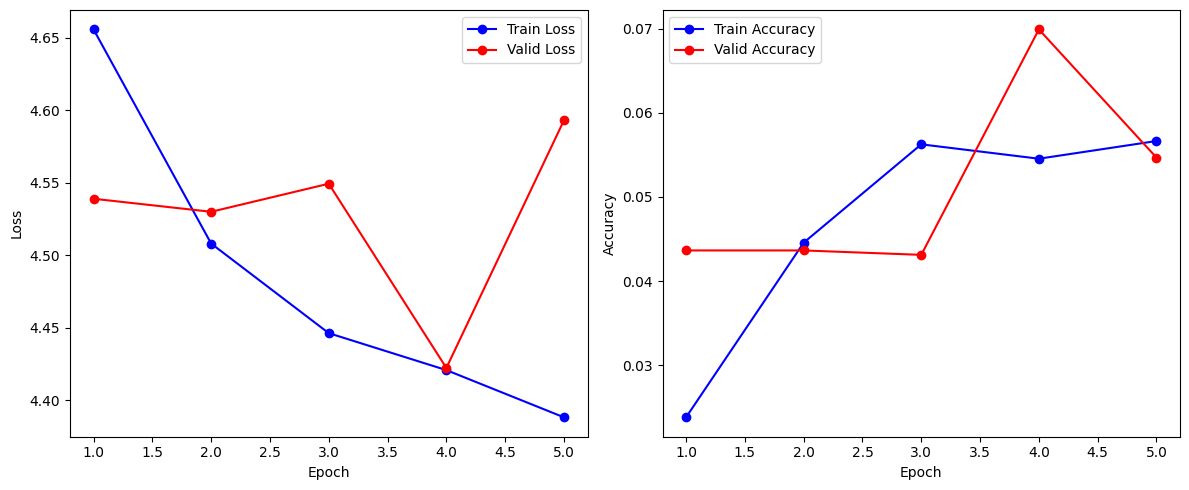

In [11]:



data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}   

full_dataset_train = MyImageFolder(train_dir) #, transform = data_transforms['train']
train_size = int(0.8 * len(full_dataset_train))  
val_size = len(full_dataset_train) - train_size

train_data, val_data = torch.utils.data.random_split(
    range(len(full_dataset_train)), [train_size, val_size], generator=torch.Generator()#.manual_seed(42)
)
#_, val_dataset = random_split(full_dataset_val, [train_size, val_size])



train_dataset = CustomDataset(full_dataset_train, train_data, transform=data_transforms['train'])
val_dataset   = CustomDataset(full_dataset_train, val_data, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


model_inc_v3 = models.inception_v3(pretrained = False)
num_ftrs = model_inc_v3.fc.in_features

model_inc_v3.fc = nn.Linear(num_ftrs, len(full_dataset_train.classes))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inc_v3.to(device)

for param in model_inc_v3.parameters():
    param.requires_grad = False
    
for param in model_inc_v3.fc.parameters():
    param.requires_grad = True

classes = full_dataset_train.classes
n_classes = len(classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_inc_v3.parameters(), lr = 0.001) #, weight_decay=1e-4

#обучение модели

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model_inc_v3.train() 
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        #forward pass for InceptionV3
        outputs = model_inc_v3(inputs)
        if isinstance(outputs, tuple):  
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model_inc_v3.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_inc_v3(inputs)
            if isinstance(outputs, tuple):  
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    #scheduler.step()
    
    
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
 

## Модель 2 - без навороченных аугментаций и с transfer learning

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 Train Loss: 4.4929 Acc: 0.0415 Val Loss: 4.3462 Acc: 0.0489
Epoch 2/5 Train Loss: 4.1263 Acc: 0.0849 Val Loss: 4.0391 Acc: 0.1104
Epoch 3/5 Train Loss: 3.8853 Acc: 0.1312 Val Loss: 3.9030 Acc: 0.1767
Epoch 4/5 Train Loss: 3.8582 Acc: 0.1435 Val Loss: 3.8934 Acc: 0.1709
Epoch 5/5 Train Loss: 3.8322 Acc: 0.1424 Val Loss: 3.9104 Acc: 0.1667


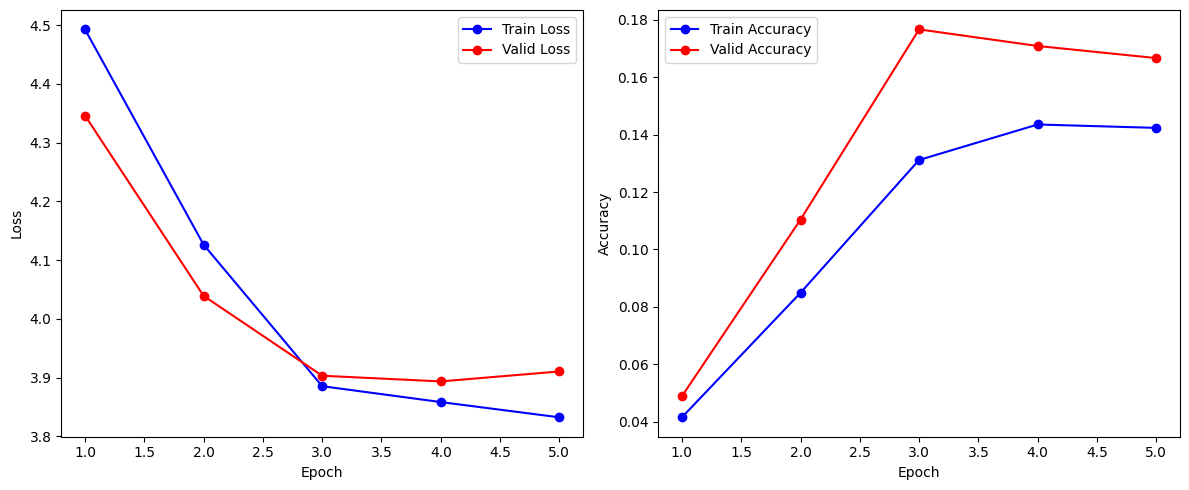

In [44]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}   

full_dataset_train = MyImageFolder(train_dir) #, transform = data_transforms['train']

train_size = int(0.8 * len(full_dataset_train))  
val_size = len(full_dataset_train) - train_size

train_data, val_data = torch.utils.data.random_split(
    range(len(full_dataset_train)), [train_size, val_size], generator=torch.Generator()#.manual_seed(42)
)
#_, val_dataset = random_split(full_dataset_val, [train_size, val_size])



train_dataset = CustomDataset(full_dataset_train, train_data, transform=data_transforms['train'])
val_dataset   = CustomDataset(full_dataset_train, val_data, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

model_inc_v3_2 = models.inception_v3(pretrained = True)
num_ftrs = model_inc_v3_2.fc.in_features

model_inc_v3_2.fc = nn.Linear(num_ftrs, len(full_dataset_train.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_inc_v3_2.to(device)

for param in model_inc_v3_2.parameters():
    param.requires_grad = False
    
for param in model_inc_v3_2.fc.parameters():
    param.requires_grad = True

classes = full_dataset_train.classes
n_classes = len(classes)

# Считаем веса классов
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_inc_v3_2.parameters(), lr = 0.001) #, weight_decay=1e-4

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) #уменьшаем лр в 10 раз каждую эпоху

#обучение модели

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model_inc_v3_2.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        #forward pass for InceptionV3
        outputs = model_inc_v3_2(inputs)
        if isinstance(outputs, tuple):  # учитываем aux_logits
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model_inc_v3_2.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_inc_v3_2(inputs)
            if isinstance(outputs, tuple):  
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    scheduler.step()
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
 

# Модель 3 - без transfer learning и со сложными аугментациями

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 Train Loss: 4.5060 Acc: 0.0266 Val Loss: 4.2798 Acc: 0.0331
Epoch 2/10 Train Loss: 4.3029 Acc: 0.0382 Val Loss: 4.1561 Acc: 0.0436
Epoch 3/10 Train Loss: 4.1845 Acc: 0.0549 Val Loss: 4.0145 Acc: 0.0636
Epoch 4/10 Train Loss: 4.1234 Acc: 0.0615 Val Loss: 3.9892 Acc: 0.0694
Epoch 5/10 Train Loss: 4.0817 Acc: 0.0687 Val Loss: 3.9648 Acc: 0.0773
Epoch 6/10 Train Loss: 4.0793 Acc: 0.0682 Val Loss: 3.9497 Acc: 0.0773
Epoch 7/10 Train Loss: 4.0610 Acc: 0.0706 Val Loss: 3.9528 Acc: 0.0768
Epoch 8/10 Train Loss: 4.0806 Acc: 0.0677 Val Loss: 3.9515 Acc: 0.0762
Epoch 9/10 Train Loss: 4.0641 Acc: 0.0680 Val Loss: 3.9571 Acc: 0.0768
Epoch 10/10 Train Loss: 4.0700 Acc: 0.0670 Val Loss: 3.9559 Acc: 0.0752


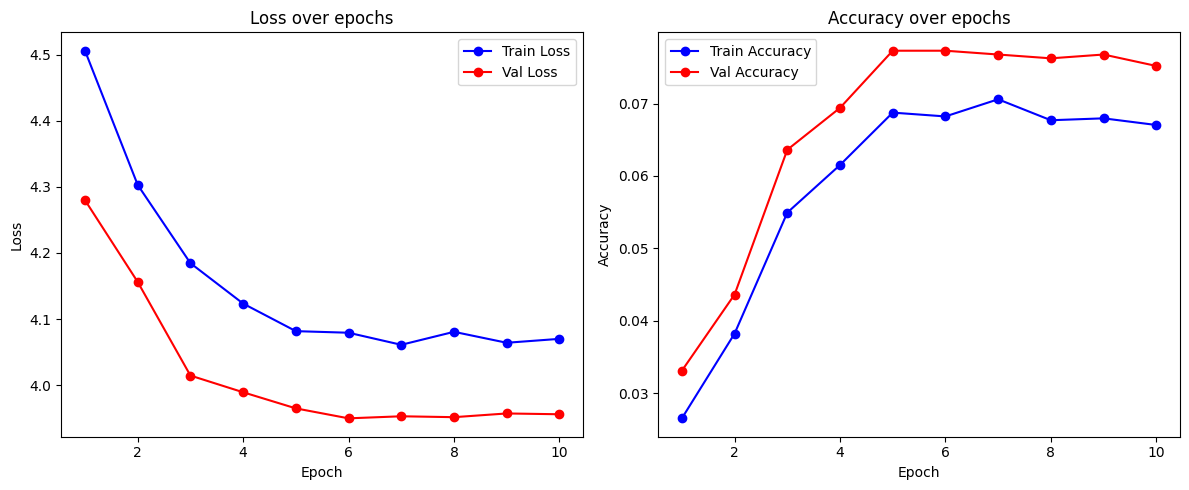

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomApply([
                 transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
                 ], p=0.2),
        transforms.RandomGrayscale(p=0.1),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.0005, 0.05), ratio=(0.3, 3.3), value=0)
        #штука убирающая пиксели
    ]),
    'valid': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}

full_dataset_train = MyImageFolder(train_dir) #, transform = data_transforms['train']
train_size = int(0.8 * len(full_dataset_train)) 
valid_size = len(full_dataset_train) - train_size
#train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_data, val_data = torch.utils.data.random_split(
    range(len(full_dataset_train)), [train_size, valid_size], generator=torch.Generator()#.manual_seed(42)
)

train_dataset = CustomDataset(full_dataset_train, train_data, transform=data_transforms['train'])
val_dataset   = CustomDataset(full_dataset_train, val_data, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=32,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)


model = models.efficientnet_b4(pretrained = False)

#замена последнего полносвязного сл
num_ftrs = model.classifier[1].in_features


model.classifier[1] = nn.Linear(num_ftrs, len(full_dataset_train.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# for param in model.parameters():
#     param.requires_grad = False
# # Новый последний слой будет обучаем
# #model.fc.requires_grad = True
# for param in model.classifier[1].parameters():
#     param.requires_grad = True

classes = full_dataset_train.classes
n_classes = len(classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001) #, weight_decay=1e-4

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) 

#обучение
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    scheduler.step()
    
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Модель 4 - с transfer learning и со сложными аугментациями

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 Train Loss: 3.3595 Acc: 0.2307 Val Loss: 1.6249 Acc: 0.5584
Epoch 2/10 Train Loss: 2.1111 Acc: 0.4574 Val Loss: 1.2735 Acc: 0.6498
Epoch 3/10 Train Loss: 1.7349 Acc: 0.5443 Val Loss: 1.1481 Acc: 0.6793
Epoch 4/10 Train Loss: 1.4995 Acc: 0.6052 Val Loss: 1.0974 Acc: 0.7029
Epoch 5/10 Train Loss: 1.3565 Acc: 0.6406 Val Loss: 1.0949 Acc: 0.7108
Epoch 6/10 Train Loss: 1.2286 Acc: 0.6732 Val Loss: 1.0609 Acc: 0.7282
Epoch 7/10 Train Loss: 1.1589 Acc: 0.6861 Val Loss: 1.1393 Acc: 0.7182
Epoch 8/10 Train Loss: 1.0536 Acc: 0.7171 Val Loss: 1.0983 Acc: 0.7319
Epoch 9/10 Train Loss: 1.0168 Acc: 0.7299 Val Loss: 1.1672 Acc: 0.7229
Epoch 10/10 Train Loss: 0.9408 Acc: 0.7550 Val Loss: 1.1370 Acc: 0.7424


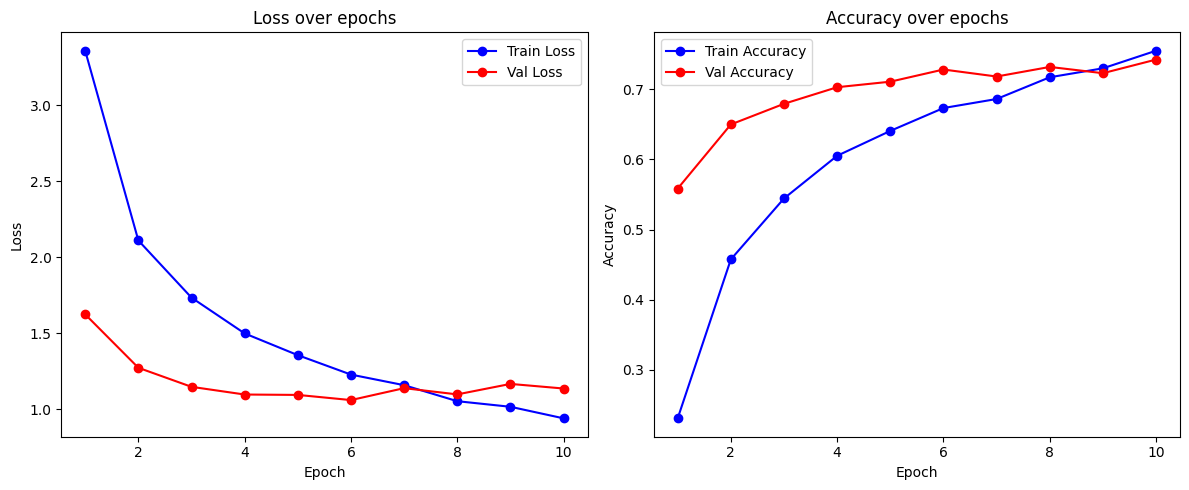

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomApply([
                 transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
                 ], p=0.2),
        transforms.RandomGrayscale(p=0.1),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.0005, 0.05), ratio=(0.3, 3.3), value=0)
        #штука убирающая пиксели
    ]),
    'valid': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}

full_dataset_train = MyImageFolder(train_dir) #, transform = data_transforms['train']
train_size = int(0.8 * len(full_dataset_train))  
valid_size = len(full_dataset_train) - train_size
#train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_data, val_data = torch.utils.data.random_split(
    range(len(full_dataset_train)), [train_size, valid_size], generator=torch.Generator()#.manual_seed(42)
)




train_dataset = CustomDataset(full_dataset_train, train_data, transform=data_transforms['train'])
val_dataset   = CustomDataset(full_dataset_train, val_data, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=32,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)


model4 = models.efficientnet_b4(pretrained = True)
num_ftrs = model4.classifier[1].in_features


model4.classifier[1] = nn.Linear(num_ftrs, len(full_dataset_train.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4.to(device)

classes = full_dataset_train.classes
n_classes = len(classes)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr = 0.001) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) #уменьшаем лр в 10 раз каждую эпоху

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model4.train() 
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model4(inputs)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model4.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model4(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(full_dataset_train.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for param in model.parameters():
    param.requires_grad = False
# Новый последний слой будет обучаем
#model.fc.requires_grad = True
for param in model.classifier[1].parameters():
    param.requires_grad = True

classes = full_dataset_train.classes
n_classes = len(classes)

# Считаем веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(n_classes),
    y=[label for _, label in full_dataset_train]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr = 0.001) #, weight_decay=1e-4
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) 

#обучение модели
num_epochs = 7
for epoch in range(num_epochs):
    model.train() #установка модели в режим обучения
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        #forward pass for InceptionV3
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    
    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    #scheduler.step()
    
for param in model.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
num_epochs_stage2 = 12
print('Дообучение модели')
model.classifier[0] = nn.Dropout(p=0.4)

for epoch in range(num_epochs_stage2):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs_stage2} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

    #scheduler.step()    
    


Epoch 1/7 Train Loss: 4.4785 Acc: 0.0911 Val Loss: 4.2718 Acc: 0.2171
Epoch 2/7 Train Loss: 4.2043 Acc: 0.1610 Val Loss: 3.9821 Acc: 0.3123
Epoch 3/7 Train Loss: 3.9986 Acc: 0.1977 Val Loss: 3.7435 Acc: 0.3307
Epoch 4/7 Train Loss: 3.8436 Acc: 0.2140 Val Loss: 3.5528 Acc: 0.3675
Epoch 5/7 Train Loss: 3.7046 Acc: 0.2325 Val Loss: 3.3785 Acc: 0.3796
Epoch 6/7 Train Loss: 3.6153 Acc: 0.2399 Val Loss: 3.2244 Acc: 0.4001
Epoch 7/7 Train Loss: 3.5436 Acc: 0.2472 Val Loss: 3.1268 Acc: 0.4196
=== Этап 2: дообучение всей модели ===
Epoch 1/12 Train Loss: 2.8898 Acc: 0.3368 Val Loss: 1.7931 Acc: 0.5831
Epoch 2/12 Train Loss: 2.3831 Acc: 0.4239 Val Loss: 1.4200 Acc: 0.6530
Epoch 3/12 Train Loss: 2.1303 Acc: 0.4750 Val Loss: 1.1619 Acc: 0.6887
Epoch 4/12 Train Loss: 1.9687 Acc: 0.5038 Val Loss: 1.0044 Acc: 0.7240
Epoch 5/12 Train Loss: 1.8248 Acc: 0.5287 Val Loss: 0.8676 Acc: 0.7581
Epoch 6/12 Train Loss: 1.7156 Acc: 0.5564 Val Loss: 0.7709 Acc: 0.7829
Epoch 7/12 Train Loss: 1.6255 Acc: 0.5837 Val

# Зафиксированная модель для счета на Kaggle - дает результат 0.8 на public



При анализе датасета был обнаружен дисбаланс классов, поэтому в итоговой модели используются способы борьбы с этим, например функция потерь использующая этот дисбаланс с помощью весов. Кроме того усилена аугментация: класс UnsharpMask - используется для повышения резкости изображений, добавление шумов, размытия и т.п.
Также в модели используется двухэтапное обучение - сначала модель обучается с большим learning rate, а после он уменьшается. Цель - сначала быстро достичь хорошего минимума, а после дойти до более устойчивого минимума без перерегулировки.

In [12]:
train_dir = '/home/jupyter/datasphere/data/data/train'
test_dir ='/home/jupyter/datasphere/data/data/test'

In [13]:
class UnsharpMask(object):
    def __init__(self, sigma=1.0, strength=1.5):
        self.sigma = sigma  
        self.strength = strength  

    def __call__(self, img):
        img = np.array(img)

        # Применяем размытие Гаусса
        blurred = cv2.GaussianBlur(img, (5, 5), self.sigma)

        # Применяем Unsharp Mask
        sharpened = cv2.addWeighted(img, self.strength, blurred, -0.5, 0)

        return Image.fromarray(sharpened)

class OneOfTransform:
    def __init__(self, transforms_list, p=0.7):
        self.transforms = transforms_list
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            transform = random.choice(self.transforms)
            img = transform(img)
        return img
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(tensor + noise, 0., 1.)
    
one_of_transform = OneOfTransform([
    #AddGaussianNoise(mean=0., std=0.02),  # заменяет A.GaussNoise
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=1),  
    #transforms.RandomApply([transforms.ColorJitter(hue=0.1, saturation=0.3)], p=0.8),  
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.5)),  # заменяет GaussianBlur
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=1.0),  
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.05, 0.05))], p=1.0)  
], p=0.7)

In [14]:
class MyImageFolder(datasets.ImageFolder):
    def find_class(self, directory):
        classes = sorted([d.name for d in os.scandir(directory) if d.is_dir()], key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [15]:
train_dir = '/home/jupyter/datasphere/data/data/train'
test_dir ='/home/jupyter/datasphere/data/data/test'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(512),
        transforms.Resize(380),
        transforms.RandomResizedCrop(380),
        transforms.CenterCrop(380),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        # transforms.RandomApply([
        #          transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        #          ], p=0.2),
        
        transforms.RandomGrayscale(p=0.1),
        
        transforms.RandomApply([UnsharpMask(sigma=1.0, strength=1.5)], p=0.4),
            
        transforms.ToTensor(),
        one_of_transform,
        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.0005, 0.05), ratio=(0.3, 3.3), value=0)
        
    ]),
    'valid': transforms.Compose([
        transforms.Resize(512),
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(512),
        transforms.Resize(380),
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}  

In [16]:
full_dataset_train = MyImageFolder(train_dir) #, transform = data_transforms['train']

train_size = int(0.8 * len(full_dataset_train))  
valid_size = len(full_dataset_train) - train_size
train_data, val_data = torch.utils.data.random_split(
    range(len(full_dataset_train)), [train_size, valid_size], generator=torch.Generator()#.manual_seed(42)
)


train_dataset = CustomDataset(full_dataset_train, train_data, transform=data_transforms['train'])
val_dataset   = CustomDataset(full_dataset_train, val_data, transform=data_transforms['valid'])

train_dataloader = DataLoader(train_dataset, batch_size=32,  num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)


In [17]:
model_kaggle = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs = model_kaggle.classifier[1].in_features
model_kaggle.classifier[1] = nn.Linear(num_ftrs, len(full_dataset_train.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_kaggle.to(device)

for param in model_kaggle.parameters():
    param.requires_grad = False

for param in model_kaggle.classifier[1].parameters():
    param.requires_grad = True

#model.classifier[0] = nn.Dropout(p=0.3)

#определение функции потерь и оптимизатора
classes = full_dataset_train.classes
n_classes = len(classes)

# Считаем веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(n_classes),
    y=[label for _, label in full_dataset_train]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_kaggle.parameters(), lr = 0.001, weight_decay=1e-4) #, weight_decay=1e-4

#планировщик для изменения ренинг рейт
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) #уменьшаем лр в 10 раз каждую эпоху

#обучение модели
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 9
for epoch in range(num_epochs):
    model_kaggle.train() #установка модели в режим обучения
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_kaggle(inputs)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    #print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    model_kaggle.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_kaggle(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc.item())
    print(f'Epoch {epoch + 1}/{num_epochs} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
    
for param in model_kaggle.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model_kaggle.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
num_epochs_stage2 = 20
print('Дообучение модели')
model_kaggle.classifier[0] = nn.Dropout(p=0.4)

for epoch in range(num_epochs_stage2):
    model_kaggle.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_kaggle(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    model_kaggle.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_kaggle(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = val_corrects.double() / len(val_dataset)
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc.item())
    
    print(f'Epoch {epoch+1}/{num_epochs_stage2} '
          f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
          f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

    
   
epochs = range(1, num_epochs + num_epochs_stage2 + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 93.1MB/s]


Epoch 1/9 Train Loss: 4.4819 Acc: 0.0910 Val Loss: 4.2933 Acc: 0.2271
Epoch 2/9 Train Loss: 4.2100 Acc: 0.1747 Val Loss: 4.0402 Acc: 0.2634
Epoch 3/9 Train Loss: 4.0143 Acc: 0.1905 Val Loss: 3.8231 Acc: 0.2960
Epoch 4/9 Train Loss: 3.8722 Acc: 0.2085 Val Loss: 3.6416 Acc: 0.3181
Epoch 5/9 Train Loss: 3.7436 Acc: 0.2280 Val Loss: 3.5098 Acc: 0.3275
Epoch 6/9 Train Loss: 3.6324 Acc: 0.2437 Val Loss: 3.3603 Acc: 0.3623
Epoch 7/9 Train Loss: 3.5565 Acc: 0.2549 Val Loss: 3.2768 Acc: 0.3665
Epoch 8/9 Train Loss: 3.4976 Acc: 0.2538 Val Loss: 3.1712 Acc: 0.3780
Epoch 9/9 Train Loss: 3.4624 Acc: 0.2581 Val Loss: 3.0854 Acc: 0.3933
Дообучение модели
Epoch 1/20 Train Loss: 2.8011 Acc: 0.3532 Val Loss: 1.8913 Acc: 0.5605


KeyboardInterrupt: 

дальше обучение на алл трейне

In [37]:
train_dataset = MyImageFolder(train_dir, transform = data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)

In [38]:
model_kaggle_itog = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs = model_kaggle_itog.classifier[1].in_features
model_kaggle_itog.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_kaggle_itog.to(device)

for param in model_kaggle_itog.parameters():
    param.requires_grad = False
for param in model_kaggle_itog.classifier[1].parameters():
    param.requires_grad = True

classes = train_dataset.classes
n_classes = len(classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(n_classes),
    y=[label for _, label in train_dataset]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model_kaggle_itog.parameters(), lr = 0.001, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1) 

#обучение модели
num_epochs = 9
for epoch in range(num_epochs):
    model_kaggle_itog.train() #установка модели в режим обучения
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_kaggle_itog(inputs)
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    print(f'Epoch {epoch + 1} / {num_epochs} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
    #model.eval()

    
for param in model_kaggle_itog.parameters():
    param.requires_grad = True
    
optimizer = optim.Adam(model_kaggle_itog.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
num_epochs_stage2 = 20
print('=== Этап 2: дообучение всей модели ===')
model_kaggle_itog.classifier[0] = nn.Dropout(p=0.4)

for epoch in range(num_epochs_stage2):
    model_kaggle_itog.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_kaggle_itog(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f'Epoch {epoch + 1} / {num_epochs_stage2} Train Loss: {epoch_loss: .4f} Train Acc: {epoch_acc: .4f}')
 

Epoch 1 / 9 Train Loss:  4.4582 Train Acc:  0.0833
Epoch 2 / 9 Train Loss:  4.1887 Train Acc:  0.1646
Epoch 3 / 9 Train Loss:  3.9913 Train Acc:  0.1880
Epoch 4 / 9 Train Loss:  3.8375 Train Acc:  0.2090
Epoch 5 / 9 Train Loss:  3.7348 Train Acc:  0.2166
Epoch 6 / 9 Train Loss:  3.6521 Train Acc:  0.2246
Epoch 7 / 9 Train Loss:  3.5841 Train Acc:  0.2313
Epoch 8 / 9 Train Loss:  3.5104 Train Acc:  0.2401
Epoch 9 / 9 Train Loss:  3.4847 Train Acc:  0.2333
=== Этап 2: дообучение всей модели ===
Epoch 1 / 22 Train Loss:  2.8829 Train Acc:  0.3280
Epoch 2 / 22 Train Loss:  2.3587 Train Acc:  0.4229
Epoch 3 / 22 Train Loss:  2.1263 Train Acc:  0.4677
Epoch 4 / 22 Train Loss:  1.9382 Train Acc:  0.5048
Epoch 5 / 22 Train Loss:  1.7818 Train Acc:  0.5383
Epoch 6 / 22 Train Loss:  1.6932 Train Acc:  0.5565
Epoch 7 / 22 Train Loss:  1.6155 Train Acc:  0.5748
Epoch 8 / 22 Train Loss:  1.5455 Train Acc:  0.5964
Epoch 9 / 22 Train Loss:  1.4835 Train Acc:  0.6038
Epoch 10 / 22 Train Loss:  1.4183 

In [39]:
test_dataset = Loadingtest(test_dir, transform = data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 4)

model.eval()
test_predictions = []
image_names = []

for inputs, names in test_dataloader:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        image_names.extend(names)
#
print('10 первых предсказаний')
for i in range(10):
    print(f'Изображение {test_dataset.images[i]}, Предскаазание, {test_predictions[i]}')

10 первых предсказаний
Изображение 0.png, Предскаазание, 71
Изображение 1.png, Предскаазание, 62
Изображение 10.png, Предскаазание, 32
Изображение 100.png, Предскаазание, 19
Изображение 1000.png, Предскаазание, 40
Изображение 1001.png, Предскаазание, 71
Изображение 1002.png, Предскаазание, 59
Изображение 1003.png, Предскаазание, 98
Изображение 1004.png, Предскаазание, 85
Изображение 1005.png, Предскаазание, 91


In [40]:
submission = pd.DataFrame({
    'id': image_names,
    'label': test_predictions
})

In [41]:
submission['id'] = submission['id'].str.replace('.png', '', regex=False).astype(int)
submission = submission.sort_values('id').reset_index(drop=True)


In [43]:
submission.to_csv('submission.csv', index=False)
print("Файл submission.csv успешно сохранен")

Файл submission.csv успешно сохранен


In [42]:
submission

,id,label
0,0,71
1,1,62
2,2,77
3,3,1
4,4,92
...,...,...
3873,3873,94
3874,3874,42
3875,3875,95
3876,3876,91
